# Benchmarks 

In [127]:
import sklearn
import sklearn.datasets
from sklearn.linear_model import ElasticNet
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from skopt import BayesSearchCV
import lipo
import optuna
import numpy as np
import matplotlib.pyplot as plt

## California housing dataset

In [128]:
data = sklearn.datasets.load_boston()
x, y = data.data, data.target
n_trails = 50
n_iter = 10
cv = 3
params = {"alpha": [1e-3, 10.0, "log"], "l1_ratio": [0.5, 1.0]}
fixed_params = {"normalize": True, "max_iter": 100000}

### Optuna

In [129]:
def objective(trial):
    suggestions = {}
    for name, values in params.items():
        if values[-1] == "log":
            if isinstance(values[0], int):
                suggestions[name] = int(trial.suggest_loguniform(name, values[0], values[1]))
            else:
                suggestions[name] = trial.suggest_loguniform(name, values[0], values[1])
        elif isinstance(values[0], int):
            suggestions[name] = trial.suggest_integer(name, values[0], values[1])
        else:
            suggestions[name] = trial.suggest_float(name, values[0], values[1])

    score = sklearn.model_selection.cross_val_score(ElasticNet(normalize=True, **suggestions), x, y, n_jobs=1, cv=cv)
    accuracy = score.mean()
    return accuracy


optuna_values = []
for _ in range(n_trails):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_iter, n_jobs=-1)
    optuna_values.append([s.value for s in study.trials])

optuna_values = np.asarray(optuna_values)

[I 2020-05-25 22:18:33,955] Finished trial#0 with value: 0.3584703291262888 with parameters: {'alpha': 0.00882128341807773, 'l1_ratio': 0.7063661939789624}. Best is trial#0 with value: 0.3584703291262888.
[I 2020-05-25 22:18:34,286] Finished trial#1 with value: -0.35425097711527526 with parameters: {'alpha': 0.1259728342300861, 'l1_ratio': 0.8729433808460532}. Best is trial#0 with value: 0.3584703291262888.
[I 2020-05-25 22:18:34,288] Finished trial#9 with value: 0.3431869922206581 with parameters: {'alpha': 0.027543588813935, 'l1_ratio': 0.9748442126198793}. Best is trial#0 with value: 0.3584703291262888.
[I 2020-05-25 22:18:34,444] Finished trial#4 with value: -0.14731537408742434 with parameters: {'alpha': 0.10791848872273138, 'l1_ratio': 0.9434138935016693}. Best is trial#0 with value: 0.3584703291262888.
[I 2020-05-25 22:18:34,976] Finished trial#6 with value: -0.689073272086322 with parameters: {'alpha': 4.307305958666719, 'l1_ratio': 0.5502615943215852}. Best is trial#0 with val

### LIPO

In [130]:
lipo_values = []
for _ in range(n_trails):
    lipo_search = lipo.LIPOSearchCV(
        estimator=ElasticNet(normalize=True),
        cv=cv,
        n_iter=n_iter,
        random_state=np.random.randint(1, 1000),
        param_space={name: values[:2] for name, values in params.items()},
        log_args=[name for name, values in params.items() if values[-1] == "log"],
    )
    lipo_search.fit(x, y)
    lipo_values.append(lipo_search.cv_results_["mean_test_score"])

lipo_values = np.asarray(lipo_values)

### Random

In [131]:
random_values = []
for _ in range(n_trails):
    param_distributions = {}
    
    for name, values in params.items():
        if values[-1] == "log" and not isinstance(values[0], int):
            param_distributions[name] = scipy.stats.loguniform(values[0], values[1])
        elif isinstance(values[0], int):
            param_distributions[name] = scipy.stats.randint(values[0], values[1])
        else:
            param_distributions[name] = scipy.stats.uniform(values[0], values[1])
    random_search = RandomizedSearchCV(
        estimator=ElasticNet(normalize=True),
        cv=cv,
        n_iter=n_iter,
        param_distributions=param_distributions,
    )
    random_search.fit(x, y)
    random_values.append(random_search.cv_results_["mean_test_score"])

random_values = np.asarray(random_values)

/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.986551423768105, tolerance: 3.419845810089021



/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.336158247311687, tolerance: 2.4660454319526623

/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 3.419845810089021

/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 2.1169160949554895

/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

### Bayesian (scikit-opt)

In [132]:
bayes_values = []
for _ in range(n_trails):
    search_spaces = {}
    
    for name, values in params.items():
        if values[-1] == "log" and not isinstance(values[0], int):
            search_spaces[name] = (values[0], values[1], "log-uniform")
        else:
            search_spaces[name] = (values[0], values[1])
    bayes_search = BayesSearchCV(
        estimator=ElasticNet(normalize=True),
        n_jobs=1,
        cv=cv,
        n_iter=n_iter,
        search_spaces=search_spaces,
    )
    bayes_search.fit(x, y)
    bayes_values.append(bayes_search.cv_results_["mean_test_score"])

bayes_values = np.asarray(bayes_values)

### Results 

(-0.5, 0.5)

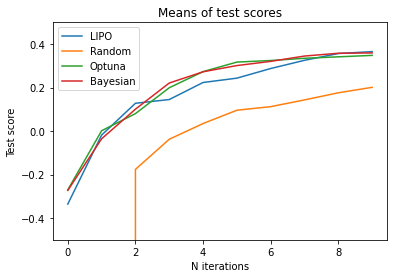

In [133]:
# summary
fig, ax = plt.subplots()
for idx, name, values in zip(
    list(range(4)),
    ["LIPO", "Random", "Optuna", "Bayesian"],
    [lipo_values, random_values, optuna_values, bayes_values],
):
    ax.plot(np.mean(np.maximum.accumulate(values, axis=1), axis=0), label=name)
    
ax.set_title("Means of test scores")
ax.set_ylabel("Test score")
ax.set_xlabel("N iterations")
ax.legend();
ax.set_ylim([-.5, 0.5])

We see a clear benefit of using LIPO. While it looks as if LIPO had an unfair advantage starting from a higher level this is only the result from choosing the starting point in the middle of the search range. It looses this advantage in the later
iterations as it explores the rest of the space.

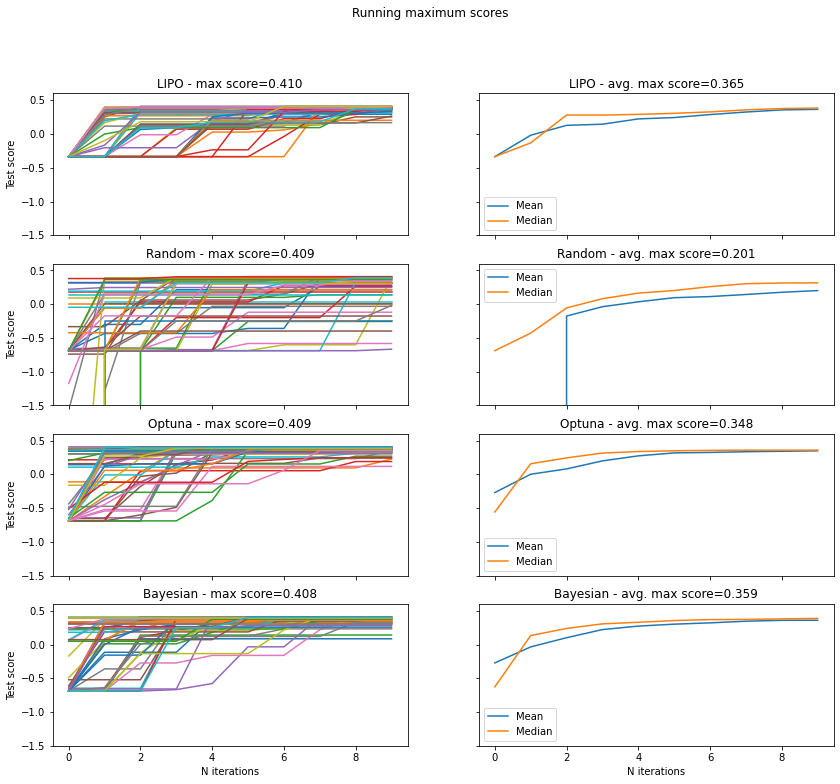

In [134]:
# details
fig, ax = plt.subplots(4, 2, figsize=(14, 12), sharey=True, sharex=True)
fig.suptitle("Running maximum scores")

for idx, name, values in zip(
    list(range(4)),
    ["LIPO", "Random", "Optuna", "Bayesian"],
    [lipo_values, random_values, optuna_values, bayes_values],
):
    for val in values:
        ax[idx][0].plot(np.maximum.accumulate(val))

    ax[idx][1].plot(np.mean(np.maximum.accumulate(values, axis=1), axis=0), label="Mean")
    ax[idx][1].plot(np.median(np.maximum.accumulate(values, axis=1), axis=0), label="Median")
    ax[idx][1].legend()

    ax[idx][0].set_title(f"{name} - max score={values.max():.3f}")
    ax[idx][1].set_title(f"{name} - avg. max score={values.max(axis=1).mean():.3f}")
    ax[idx][0].set_ylabel("Test score")

if idx == 3:
    ax[idx][0].set_xlabel("N iterations")
    ax[idx][1].set_xlabel("N iterations")
    
ax[0][0].set_ylim(-1.5, 0.6);

LIPO seems to hit the maximum almost every time while others are a bit more varied. Also, it hits consistently higher scores.

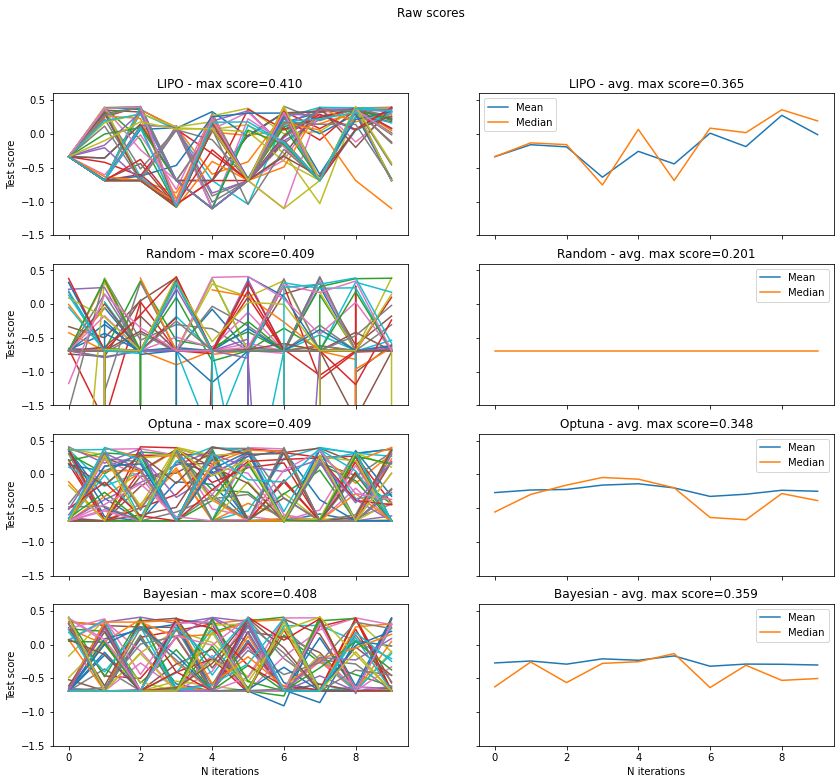

In [135]:
# details
fig, ax = plt.subplots(4, 2, figsize=(14, 12), sharey=True, sharex=True)
fig.suptitle("Raw scores")

for idx, name, values in zip(
    list(range(4)),
    ["LIPO", "Random", "Optuna", "Bayesian"],
    [lipo_values, random_values, optuna_values, bayes_values],
):
    for val in values:
        ax[idx][0].plot(val)

    ax[idx][1].plot(np.mean(values, axis=0), label="Mean")
    ax[idx][1].plot(np.median(values, axis=0), label="Median")
    ax[idx][1].legend()

    ax[idx][0].set_title(f"{name} - max score={values.max():.3f}")
    ax[idx][1].set_title(f"{name} - avg. max score={values.max(axis=1).mean():.3f}")
    ax[idx][0].set_ylabel("Test score")

if idx == 3:
    ax[idx][0].set_xlabel("N iterations")
    ax[idx][1].set_xlabel("N iterations")
ax[0][0].set_ylim(-1.5, 0.6);

We see that all algorithms explore a wide range of parameters. LIPO is the only one that has a clear upward trend in test scores over the number of iterations.

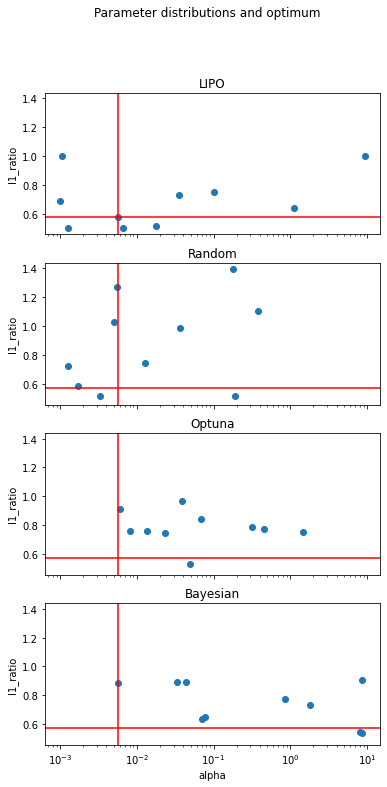

In [140]:
import pandas as pd

fig, ax = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(6, 12))
fig.suptitle("Parameter distributions and optimum")

for idx, name, search in zip(list(range(4)), ["LIPO", "Random", "Optuna", "Bayesian"], [lipo_search, random_search, study, bayes_search]):
    if isinstance(search, optuna.study.BaseStudy):
        df = pd.DataFrame([s.params for s in study.trials])
    else:
        df = pd.DataFrame(search.cv_results_["params"])
    ax[idx].scatter(df["alpha"], df["l1_ratio"])
    ax[idx].axhline(lipo_search.best_params_["l1_ratio"], c="r")
    ax[idx].axvline(lipo_search.best_params_["alpha"], c="r")
    ax[idx].set_ylabel("l1_ratio")
    ax[idx].set_title(name)
    
ax[idx].set_xlabel("alpha");
ax[idx].set_xscale("log");